# CMPT 419 Final Project - Object Related Affect

## Setup and Pre-processing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics 
from PIL import Image, ImageDraw
from IPython.display import display
from math import cos, sin
os.chdir("/content/drive/My Drive")

We can remove the rows with low confidence and unsuccessful images. Unsuccessful images are both those that OpenFace could not recognize a face in, as well as ones that we removed due to having multiple faces present.  

We also removed the features for 2D and 3D landmarks, as well as rigid and non-rigid shape parameters. We kept features relating to AUs, eye gaze, head movement, and the bounding box of the object. More information on the features can be found at https://github.com/TadasBaltrusaitis/OpenFace/wiki/Output-Format. 


In [ ]:
annotations = pd.read_csv('annotationsv3.csv') 
annotations.head()
len(annotations)

8776

In [ ]:
# Filter out low confidence and unsuccessful entries
df = pd.read_csv('train_cleaned.csv')
df.drop(df.columns[df.columns.str.contains('Unnamed')], axis=1, inplace=True)
df.columns = df.columns.str.replace(' ', '') # remove unwanted space
df = df[df.confidence>=.80]
df = df[df.success == 1] # get rid of rows where success = 0
df.dropna(how='any')

# Add annotations from COCO
annotations = pd.read_csv('annotationsv3.csv') 
annotations.drop(annotations.columns[annotations.columns.str.contains('Unnamed')], axis=1, inplace=True)
annotations.photo = annotations.photo.apply(lambda x: str(x).zfill(12)).astype(str)
df.photo = df.photo.apply(lambda x: str(x).zfill(12)).astype(str)

In [ ]:
merged = pd.merge(df, annotations, on='photo')  # merged is a dataframe object
merged = merged[merged.category == 'cake'] # remove non cake objects
len(merged) # number of rows in merged dataframe

509

In [ ]:
%cd 'Training_set_single_face_pics'
# !ls
# !cd 'Training_set_single_face_pics/Training_set_single_face_pics'

/content/drive/My Drive/Training_set_single_face_pics/Training_set_single_face_pics


Next, we will add a feature to test if the person is looking at the food or not. We hypothesize that people looking at the cake will have a higher intensity of happiness. 

**TODO:** the code below has errors. Scroll to see examples of the photos and their ruling by the code. The first three seem correct, the last one is way off. We may need to try more images to see if this code will work for most cases, or we may need to modify it. 

In [ ]:
def draw_gaze(sample):
    file_name = sample.photo + ".jpg"
    print("photo: ", file_name) # trace comment
    source_img = Image.open(file_name)

    width, height = source_img.size

    left_x, right_x = sample.eye_lmk_x_6, sample.eye_lmk_x_34
    left_y, right_y = sample.eye_lmk_y_6, sample.eye_lmk_y_34

    # get endpoints for left eye
    endpoint_left_x = (sample.gaze_angle_x * 2 * width) + left_x
    endpoint_left_y = (sample.gaze_angle_y * 2 * height) + left_y

    # get endpoints for right eye
    endpoint_right_x = (sample.gaze_angle_x * 2 * width) + right_x
    endpoint_right_y = (sample.gaze_angle_y * 2 * height) + right_y

    left_line = [(left_x, left_y), (endpoint_left_x, endpoint_left_y)] # line for left eye
    right_line = [(right_x, right_y), (endpoint_right_x, endpoint_right_y)] # line for left eye

    img = Image.new("RGB", (width, height)) 

    # create line image 
    img1 = ImageDraw.Draw(img)
    draw = ImageDraw.Draw(source_img)
    draw.line(left_line, fill="red", width = 2)
    draw.line(right_line, fill="green", width = 2)

    # create bounding box
    box = [(sample.xmin, sample.ymin), (sample.xmax, sample.ymax)]
    draw.rectangle(box, outline="blue", width=2)

    # detect if within box 
    # note: left_x , right_x and left_y, right_y are not changed in the for loop
    x_points = [left_x + (i * sample.gaze_angle_x) for i in range(1, 2*width)]
    x_points += [right_x + (i * sample.gaze_angle_x) for i in range(1, 2*width)]
    
    y_points = [left_y + (i * sample.gaze_angle_y) for i in range(1, 2*height)]
    y_points += [right_y + (i * sample.gaze_angle_y) for i in range(1, 2*height)]
   
    print("left_x = ", left_x, "left_y = ", left_y)
    print("right_x = ", right_x, "right_y = ", right_y)

    '''
    # check if left eye is looking at box
    left_x_in_box = min(left_x, left_y) <= box[0][0] <= max(left_x, left_y) or min(left_x, left_y) <= box[0][1] <= max(left_x, left_y)
    left_y_in_box = min(endpoint_left_x, endpoint_left_y) <= box[1][0] <= max(endpoint_left_x, endpoint_left_y) or min(endpoint_left_x, endpoint_left_y) <= box[1][1] <= max(endpoint_left_x, endpoint_left_y)

    # check if right eye is looking at box
    right_x_in_box = min(right_x, right_y) <= box[0][0] <= max(right_x, right_y) or min(right_x, right_y) <= box[0][1] <= max(right_x, right_y)
    right_y_in_box = min(endpoint_right_x, endpoint_right_y) <= box[1][0] <= max(endpoint_right_x, endpoint_right_y) or min(endpoint_right_x, endpoint_right_y) <= box[1][1] <= max(endpoint_right_x, endpoint_right_y)
    '''

    x_in_box = sample.xmin <= right_x <= sample.xmax or sample.xmin <= left_x <= sample.xmax
    y_in_box = sample.ymin <= right_y <= sample.ymax or sample.ymin <= left_y <= sample.ymax

    print("X in box: {}. Y in box: {}".format(x_in_box, y_in_box))
    print("Looking at photo below: {}".format(x_in_box or y_in_box))
    #print("Looking at photo below: {}".format(left_x_in_box or left_y_in_box or right_x_in_box or right_y_in_box))
    display(source_img)

draw_gaze(merged.iloc[5])
draw_gaze(merged.iloc[14])
draw_gaze(merged.iloc[22])
draw_gaze(merged.iloc[26])
draw_gaze(merged.iloc[67])
draw_gaze(merged.iloc[49])
draw_gaze(merged.iloc[53])
draw_gaze(merged.iloc[60])
draw_gaze(merged.iloc[83])

photo:  000000002525.jpg


FileNotFoundError: ignored

In [ ]:
'''
def make_line(m, x0, y0, x):
    return m * (x - x0) + y0

x_points = [make_line(sample.gaze_angle_x, left_x, left_y, x) for x in range(1, 2*width)]
y_points = [make_line(sample.gaze_angle_y, left_x, left_y, y) for y in range(1, 2*height)]
    
'''
# Note: same as code to display the line and box. 
def compute_if_looking(sample):
    file_name = sample.photo + ".jpg"
    source_img = Image.open(file_name)

    width, height = source_img.size

    # starting points
    left_x, right_x = sample.eye_lmk_x_6, sample.eye_lmk_x_34
    left_y, right_y = sample.eye_lmk_y_6, sample.eye_lmk_y_34

    # get endpoints for left eye
    endpoint_left_x = (sample.gaze_angle_x * 2 * width) + left_x
    endpoint_left_y = (sample.gaze_angle_y * 2 * height) + left_y

    # get endpoints for right eye
    endpoint_right_x = (sample.gaze_angle_x * 2 * width) + right_x
    endpoint_right_y = (sample.gaze_angle_y * 2 * height) + right_y

    # create bounding box
    box = [(sample.xmin, sample.ymin), (sample.xmax, sample.ymax)]

    x_in_box = sample.xmin <= right_x <= sample.xmax or sample.xmin <= left_x <= sample.xmax
    y_in_box = sample.ymin <= right_y <= sample.ymax or sample.ymin <= left_y <= sample.ymax
    return x_in_box or y_in_box

merged['is_looking'] = merged.apply(compute_if_looking, axis=1) #computes for each row

In [ ]:
#len(merged[merged.is_looking == True]) #245
len(merged[merged.is_looking == False]) #264

264

In [ ]:
%cd ..
%cd '/content/drive/My Drive'

In [ ]:
'''
# Note: this code is probably no longer needed, though we may still want object category?
annot_cols = ['xmin', 'ymin', 'xmax', 'ymax', 'category_id', 'category']
annot = pd.DataFrame()

for col in annot_cols:
  photos = annotations.groupby("photo")[col].apply(list)
  photos = photos.to_frame().reset_index()
  annot['photo'] = photos['photo']
  annot[col] = photos[col]

merged = pd.merge(df, annot, on='photo')
'''

In [ ]:
df = merged 

NameError: ignored

In [ ]:
# Select relevant features
main_cols = ['confidence', 'success', 'emotion', 'intensity', 'is_looking']
aus = df.columns[df.columns.str.contains('\d_r', regex=True)]
# NOTE: may want to look at gaze vectors too?
gaze = df.columns[df.columns.str.contains('gaze_angle')]
eye = df.columns[df.columns.str.contains('eye')]
pose = df.columns[df.columns.str.contains('pose')]

# Filter irrelevant features out of dataframe 
needed = aus.append([gaze, pose])
needed_cols = [col for col in df.columns if col in needed or col in main_cols]
df = df[needed_cols]

# Encode category as numeric value
#df.category = pd.Categorical(df.category)
#df['category'] = df.category.cat.codes

df.head()

,confidence,gaze_angle_x,gaze_angle_y,pose_Tx,pose_Ty,pose_Tz,pose_Rx,pose_Ry,pose_Rz,AU01_r,AU02_r,AU04_r,AU05_r,AU06_r,AU07_r,AU09_r,AU10_r,AU12_r,AU14_r,AU15_r,AU17_r,AU20_r,AU23_r,AU25_r,AU26_r,AU45_r,emotion,intensity,success,is_looking
3,0.98,0.408,0.486,226.2,-247.6,991.0,0.546,-0.698,0.215,0,0,1.17,0,0.6,0.67,0,1.84,0.33,0.0,0,0,0,0,0,0,0,happy,2,1,False
4,0.98,0.408,0.486,226.2,-247.6,991.0,0.546,-0.698,0.215,0,0,1.17,0,0.6,0.67,0,1.84,0.33,0.0,0,0,0,0,0,0,0,happy,2,1,False
5,0.98,0.408,0.486,226.2,-247.6,991.0,0.546,-0.698,0.215,0,0,1.17,0,0.6,0.67,0,1.84,0.33,0.0,0,0,0,0,0,0,0,happy,2,1,False
6,0.98,0.408,0.486,226.2,-247.6,991.0,0.546,-0.698,0.215,0,0,1.17,0,0.6,0.67,0,1.84,0.33,0.0,0,0,0,0,0,0,0,happy,2,1,False
7,0.98,0.408,0.486,226.2,-247.6,991.0,0.546,-0.698,0.215,0,0,1.17,0,0.6,0.67,0,1.84,0.33,0.0,0,0,0,0,0,0,0,happy,2,1,False


To start, we can just look at entries as happy or not happy. We can change the emotion column into a boolean variable that is true when the emotion is happy, and false otherwise.

In [ ]:
# Set emotion variable to boolean variable
df.emotion[df.emotion == 'happy'] = 1
df.emotion[df.emotion != 1] = 0
df.rename(columns={'emotion': 'is_happy'}, inplace=True)

df.head

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:8765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports

<bound method NDFrame.head of       confidence  gaze_angle_x  gaze_angle_y  ...  intensity  success  is_looking
3           0.98         0.408         0.486  ...          2        1       False
4           0.98         0.408         0.486  ...          2        1       False
5           0.98         0.408         0.486  ...          2        1       False
6           0.98         0.408         0.486  ...          2        1       False
7           0.98         0.408         0.486  ...          2        1       False
...          ...           ...           ...  ...        ...      ...         ...
1014        0.88         0.040         0.138  ...          1        1       False
1016        0.88        -0.032         0.195  ...          3        1        True
1017        0.88        -0.032         0.195  ...          3        1        True
1021        0.98        -0.356         0.210  ...          1        1       False
1023        0.88         0.272         0.555  ...          4        

Split the dataset into train and test sets.

In [ ]:
X = df.drop(['is_happy', 'intensity'], 1) # X set will have the features to train the model
y = df.is_happy.astype('bool') # y set has the labels for each row. y is the column we're trying to predict
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0) # Split arrays into random train and test subsets, with test_size of 20%

## Model Selection

Next we can start exploring different classification models. We can start with a basic decision tree classifier and return the accuracy and F1 score.

Accuracy is most appropriate in balanced datasets, and has a focus on true positives and true negatives. F1 score is more robust as it takes into account false positives and false negatives, and is more appropriate for unbalanced datasets such as ours.

In [ ]:
#Initialize the classifier
dt = DecisionTreeClassifier()
dt = dt.fit(X_train,y_train)

#Get the predictions and accuracy
y_pred = dt.predict(X_test)
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("F1 Score:", metrics.f1_score(y_test, y_pred, average='binary'))

Accuracy: 0.8627450980392157
F1 Score: 0.9176470588235294


Next we can visualize the decision tree. 

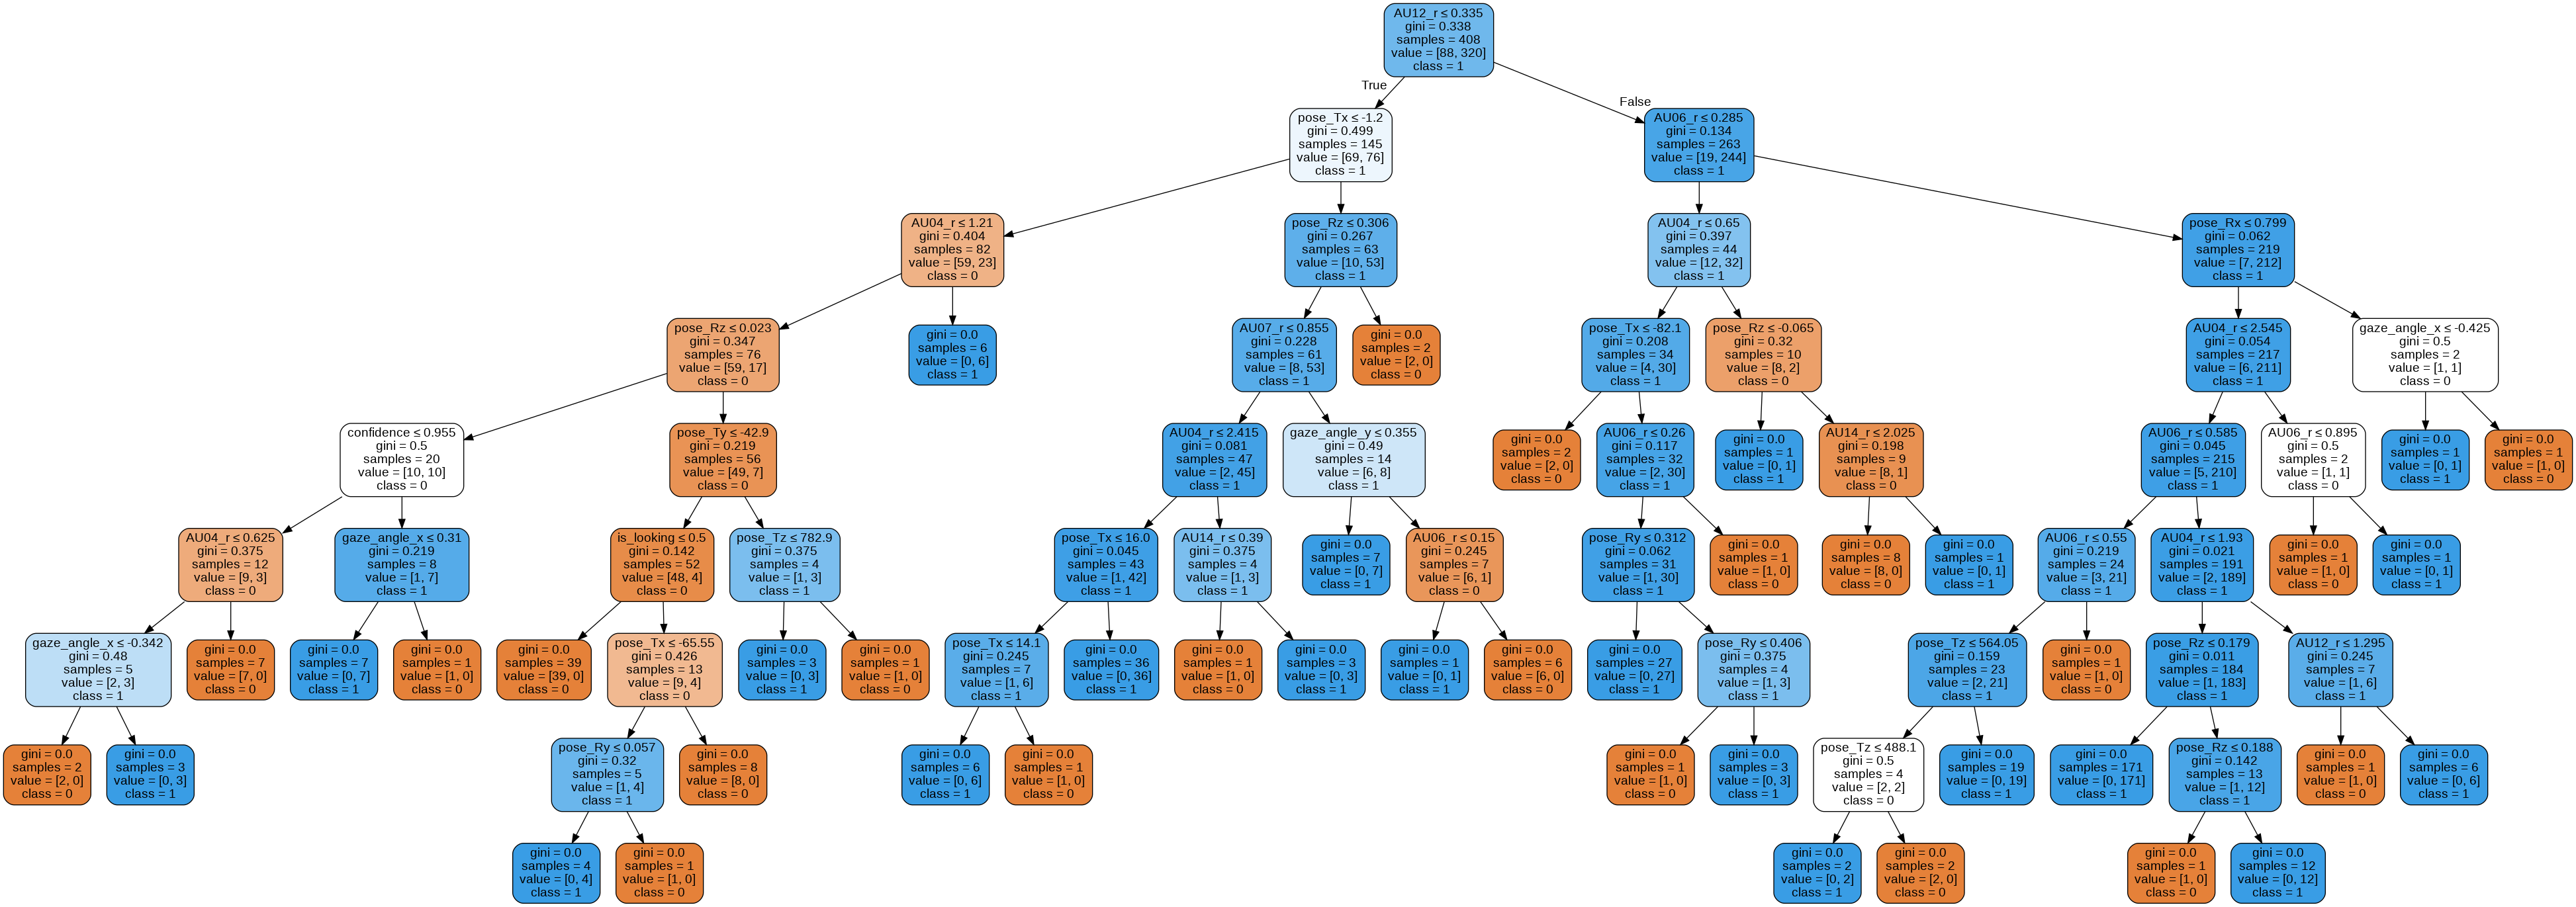

In [ ]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

dot_data = StringIO()
export_graphviz(dt, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names = X.columns, class_names=['0','1']) # class = 1 means a happy image and class = 0 means a non-happy image
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('decision_tree.png')
Image(graph.create_png())

Given the depth of the tree, it may be overfitting. 

The next model to try is Random Forest. Random Forest selects random samples from the dataset, creates a decision tree, gets a prediction from the tree, votes for each result, and then selects the prediction with the most votes as the final result. Because of the voting process, it is not as prone to overfitting since it takes the average of all predictions. 

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100)

rf = rf.fit(X_train,y_train)

# Get the predictions and accuracy
y_pred = rf.predict(X_test)
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("F1 Score:", metrics.f1_score(y_test, y_pred, average='binary')) #  the F₁ score is a measure of a test's accuracy.

Accuracy: 0.9509803921568627
F1 Score: 0.9714285714285714


Next we can take a look at the most important features. The most important features are the rotation around the X axis (pose_RX), if the person is gazing up or down (gaze_angle_y), and the intensity of AU 12, which is the lip corner pull found in smiles (AU12_r).

We may want to only include a subset of the most important features in future models to get rid of noise.

In [ ]:
importance = pd.Series(rf.feature_importances_,index=X.columns).sort_values(ascending=False)
importance

AU12_r          0.131755
gaze_angle_x    0.088332
pose_Ry         0.080481
pose_Ty         0.077104
pose_Rz         0.075987
AU06_r          0.074679
AU10_r          0.070578
pose_Tx         0.069230
pose_Rx         0.064312
gaze_angle_y    0.056645
pose_Tz         0.047931
AU07_r          0.045895
AU04_r          0.042695
AU14_r          0.041077
confidence      0.025422
is_looking      0.007875
AU05_r          0.000000
success         0.000000
AU02_r          0.000000
AU01_r          0.000000
AU09_r          0.000000
AU15_r          0.000000
AU17_r          0.000000
AU20_r          0.000000
AU23_r          0.000000
AU25_r          0.000000
AU26_r          0.000000
AU45_r          0.000000
dtype: float64

Trying a different max_depth value for Random Forest. From the manual inspection of the dataset, I perceived that there are not many different pictures, so the maximum depth of the random forest can be set to prevent overfitting the data. The decision tree has depth 8, so the max_depth is set to 10 with a little more room.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, max_depth=10 )

rf = rf.fit(X_train,y_train)

# Get the predictions and accuracy
y_pred = rf.predict(X_test)
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("F1 Score:", metrics.f1_score(y_test, y_pred, average='binary')) #  the F₁ score is a measure of a test's accuracy.

Accuracy: 0.9411764705882353
F1 Score: 0.9659090909090908


Trying a different min_samples_split value for Random Forest. A higher accuracy and F1 score is achieved by restricting min_samples_split to 60, this is likely due to the dataset not having a lot of different types of photos. Without the restriction, the Random Forest algorithm will overfit the data.

In [ ]:
rf = RandomForestClassifier(n_estimators=100, min_samples_split=60 )

rf = rf.fit(X_train,y_train)

# Get the predictions and accuracy
y_pred = rf.predict(X_test)
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("F1 Score:", metrics.f1_score(y_test, y_pred, average='binary')) #  the F₁ score is a measure of a test's accuracy.

Accuracy: 0.9411764705882353
F1 Score: 0.9662921348314606


Trying a different max_depth and min_samples_split value for Random Forest at the same time

In [ ]:
rf = RandomForestClassifier(n_estimators=100, min_samples_split=60, max_depth=50 )

rf = rf.fit(X_train,y_train)

# Get the predictions and accuracy
y_pred = rf.predict(X_test)
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("F1 Score:", metrics.f1_score(y_test, y_pred, average='binary')) #  the F₁ score is a measure of a test's accuracy.

Accuracy: 0.9411764705882353
F1 Score: 0.9662921348314606


## Predict Intensity of emotion
Note: Some code in this section is based on website https://nbviewer.jupyter.org/github/srnghn/ml_example_notebooks/blob/master/Predicting%20Yacht%20Resistance%20with%20Decision%20Trees%20%26%20Random%20Forests.ipynb

Split the dataset into train and test sets.

In [ ]:
X = df[df.is_happy == True] # only look at rows with happy emotion
X = df.drop(['is_happy', 'intensity'], 1) # drop the labels from the test set
y = df.intensity
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0) # Split arrays into random train and test subsets, with test_size of 20%

Check for X_train and X_test shape

In [ ]:
X_train.shape
X_train.columns

(408, 28)

In [ ]:
X_test.shape

(102, 28)

### Predict Intensity with Deicison Tree
Initialize the decision tree regressor. The regressor is used for predicting the numerical value. The errors should be 0 because the model is tested on the training set here. 

Abbreviations: **mse** = mean squared error, **mae** = mean absolute error, and **rmse** =  root mean squared error.

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt

#Initialize the classifier
tree_model = DecisionTreeRegressor()
tree_model.fit(X_train,y_train)

#Get the mean error for the training set
y_pred = tree_model.predict(X_train)
tree_mse = mean_squared_error(y_train, y_pred)
tree_mae = mean_absolute_error(y_train, y_pred)
print("Decision Tree training mse = ",tree_mse," & mae = ",tree_mae," & rmse = ", sqrt(tree_mse))

Decision Tree training mse =  0.0  & mae =  0.0  & rmse =  0.0


Now test the decision tree

In [ ]:
y_pred = tree_model.predict(X_test)
tree_test_mse = mean_squared_error(y_test, y_pred)
tree_test_mae = mean_absolute_error(y_test, y_pred)
print("Decision Tree test mse = ",tree_test_mse," & mae = ",tree_test_mae," & rmse = ", sqrt(tree_test_mse))

Decision Tree test mse =  1.0  & mae =  0.5686274509803921  & rmse =  1.0


Next we can visualize the decision tree. 

X.columns =  Index(['confidence', 'gaze_angle_x', 'gaze_angle_y', 'pose_Tx', 'pose_Ty',
       'pose_Tz', 'pose_Rx', 'pose_Ry', 'pose_Rz', 'AU01_r', 'AU02_r',
       'AU04_r', 'AU05_r', 'AU06_r', 'AU07_r', 'AU09_r', 'AU10_r', 'AU12_r',
       'AU14_r', 'AU15_r', 'AU17_r', 'AU20_r', 'AU23_r', 'AU25_r', 'AU26_r',
       'AU45_r', 'success', 'is_looking'],
      dtype='object')


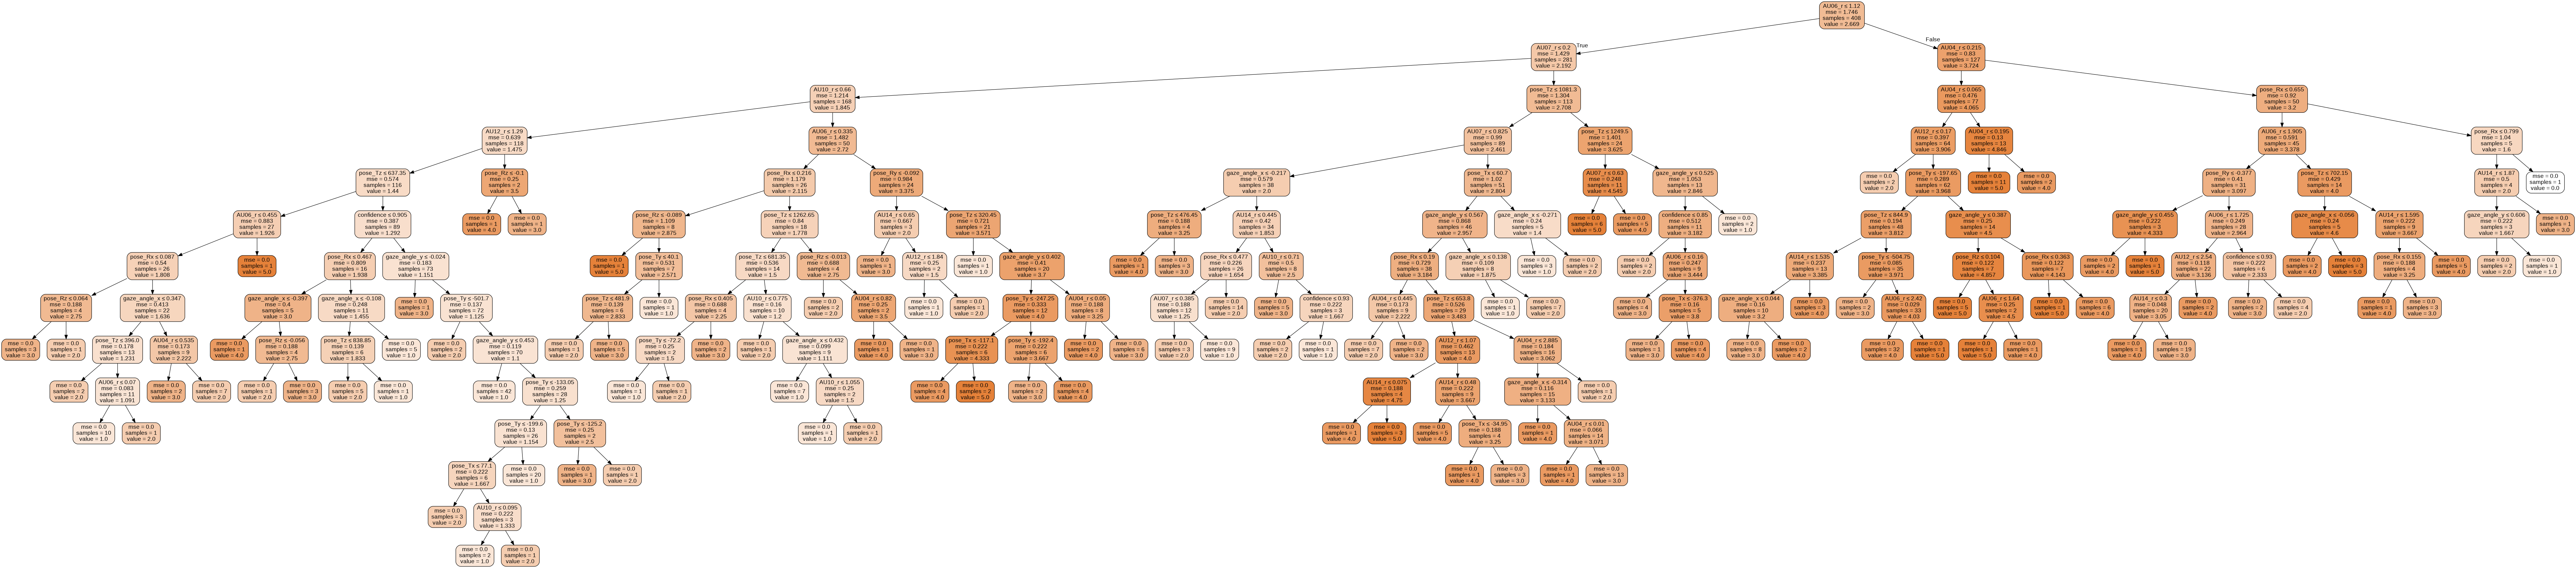

In [ ]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

dot_data = StringIO()
export_graphviz(tree_model, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names = X.columns, class_names=['1','2', '3','4','5']) # class = 1 means image with emotion little bit happy and class = 5 means image with emotion very happy
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
# graph.write_png('decision_tree_intensity.png')
# graph.set_size('"300,300!"') # set size to be larger so the text becomes readable.
# graph.write_png('decision_tree_intensity_resized.png')

#write pdf because the image is too large
graph.write_pdf("decision_tree_intensity_pdf.pdf")
Image(graph.create_png())

Look at important features for predicting intensity in the Decision Tree progressor. Interestingly, as AU12 is important to determine if a person is happy in the image, AU6 is more important to predict for intensity of happiness. AU6 is called "cheek raiser," and it makes sense, because if a person is raising their cheeks, they're likely happier. AU 12 is called "lip corner puller," and a person would be smiling if they are happy. However, if a person is smiling, it does not garauantee a high-intensity happiness. The Duchenne smile, the smile that is often classified as **real** and associated with higher intensity of happiness, is composed of AU12 and AU6, so if a person is classified as happy, the decision tree learned from the data to look at AU6 first. If a person does not have AU6, then they're likely just faking a smile and have a low intensity of happiness.

In [ ]:
importance = pd.Series(tree_model.feature_importances_,index=X.columns).sort_values(ascending=False)
importance

AU06_r          0.350508
pose_Tz         0.115521
AU07_r          0.097334
AU10_r          0.083786
pose_Rx         0.077075
AU04_r          0.057783
gaze_angle_y    0.041722
gaze_angle_x    0.030078
AU12_r          0.029816
pose_Ty         0.029009
pose_Tx         0.020322
confidence      0.019006
AU14_r          0.018096
pose_Ry         0.016230
pose_Rz         0.013713
AU09_r          0.000000
success         0.000000
AU05_r          0.000000
AU15_r          0.000000
AU02_r          0.000000
AU01_r          0.000000
AU17_r          0.000000
AU20_r          0.000000
AU23_r          0.000000
AU25_r          0.000000
AU26_r          0.000000
AU45_r          0.000000
is_looking      0.000000
dtype: float64

### Predict Intensity with Random Forest
First, we train the Random Forest and test the model with the training set.

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# initialize the Random Forest regressor 
rf_intensity_model = RandomForestRegressor()
rf_intensity_model.fit(X_train, y_train)

# test Random Forest on the training model
rf_mse = mean_squared_error(y_train, rf_intensity_model.predict(X_train))
rf_mae = mean_absolute_error(y_train, rf_intensity_model.predict(X_train))
print("Random Forest training mse = ",rf_mse," & mae = ",rf_mae," & rmse = ", sqrt(rf_mse))

Random Forest training mse =  0.08526862745098038  & mae =  0.18142156862745093  & rmse =  0.292007923609926


Test Random Forest regressor with testing set. The errors made by Random Forest are smaller than errors made by Decision Tree. Random Forest is a more accurate model than Decision Tree.

In [ ]:
rf_test_mse = mean_squared_error(y_test, rf_intensity_model.predict(X_test))
rf_test_mae = mean_absolute_error(y_test, rf_intensity_model.predict(X_test))
print("Random Forest test mse = ",rf_test_mse," & mae = ",rf_test_mae," & rmse = ", sqrt(rf_test_mse))

Random Forest test mse =  0.7079000000000001  & mae =  0.5419607843137255  & rmse =  0.8413679337840254


Look at what is important in the Random Forest model. Like the Decision Tree model, AU6 is also seen as the most important, but AU12 is the second most important in Random Forest. 

In [ ]:
importance = pd.Series(rf_intensity_model.feature_importances_,index=X.columns).sort_values(ascending=False)
importance

AU06_r          0.307051
AU12_r          0.110733
AU07_r          0.081603
AU10_r          0.074534
pose_Rx         0.063319
AU04_r          0.057259
pose_Tz         0.055552
gaze_angle_y    0.046953
pose_Tx         0.041339
pose_Ty         0.037813
pose_Rz         0.033770
AU14_r          0.029589
pose_Ry         0.021472
gaze_angle_x    0.019151
confidence      0.015872
is_looking      0.003991
AU05_r          0.000000
success         0.000000
AU02_r          0.000000
AU01_r          0.000000
AU09_r          0.000000
AU15_r          0.000000
AU17_r          0.000000
AU20_r          0.000000
AU23_r          0.000000
AU25_r          0.000000
AU26_r          0.000000
AU45_r          0.000000
dtype: float64

Do a single predict of emotion and intensity from the models that we have:

In [ ]:
# rf_intensity_model is the random forest model for intensity
# rf is the random forest classifier

print("Sample 1:")
single_sample = df[499:500]
print(single_sample) # single_sample is a dataframe
print('is_happy: ',single_sample.iloc[0]['is_happy'], ', intensity: ', single_sample.iloc[0]['intensity']) 

single_sample = single_sample.drop(['is_happy', 'intensity'], 1)

# Random Forest predicitons
prediction = rf.predict(single_sample)
print("random forest prediction: is this person happy?", prediction[0])

intensity_pred = rf_intensity_model.predict(single_sample)
print("random forest prediction: how happy is this person?", intensity_pred[0])
## It is not possible for Random Forest to limit the possible intensity values to only 1 to 5 integer values

# Decision Tree predicitons
prediction = dt.predict(single_sample)
print("Decision tree prediction: is this person happy?", prediction[0])

intensity_pred = tree_model.predict(single_sample)
print("Decision tree prediction: how happy is this person?", intensity_pred[0])

print("\nSample 2:")
single_sample = df[500:501]
print(single_sample) # single_sample is a dataframe
print('is_happy: ',single_sample.iloc[0]['is_happy'], ', intensity: ', single_sample.iloc[0]['intensity']) 

single_sample = single_sample.drop(['is_happy', 'intensity'], 1)

# Random Forest predicitons
prediction = rf.predict(single_sample)
print("random forest prediction: is this person happy?", prediction[0])

intensity_pred = rf_intensity_model.predict(single_sample)
print("random forest prediction: how happy is this person?", intensity_pred[0])
## It is not possible for Random Forest to limit the possible intensity values to only 1 to 5 integer values

# Decision Tree predicitons
prediction = dt.predict(single_sample)
print("Decision tree prediction: is this person happy?", prediction[0])

intensity_pred = tree_model.predict(single_sample)
print("Decision tree prediction: how happy is this person?", intensity_pred[0])


Sample 1:
     confidence  gaze_angle_x  gaze_angle_y  ...  intensity  success  is_looking
996        0.98         0.042          0.38  ...          5        1       False

[1 rows x 30 columns]
is_happy:  1 , intensity:  5
random forest prediction: is this person happy? True
random forest prediction: how happy is this person? 4.44
Decision tree prediction: is this person happy? True
Decision tree prediction: how happy is this person? 5.0

Sample 2:
      confidence  gaze_angle_x  gaze_angle_y  ...  intensity  success  is_looking
1002        0.88         0.012         0.314  ...          1        1        True

[1 rows x 30 columns]
is_happy:  1 , intensity:  1
random forest prediction: is this person happy? True
random forest prediction: how happy is this person? 1.99
Decision tree prediction: is this person happy? True
Decision tree prediction: how happy is this person? 3.0


## Final functions from the project

From the results, we can see that sometimes Random Forest gives decimal values even though the training set only has integers for emotion intensity. Decision tree mostly gives integer predictions.

Below is the fruit of our project, the function that will predict if an image contains a happy person and if that person is happy, predict the intensity too.  

In [ ]:
def rf_predict(sample):
  print('Sample data: is_happy: ', sample.iloc[0]['is_happy'], ', intensity: ', sample.iloc[0]['intensity']) 
  sample = sample.drop(['is_happy', 'intensity'], 1)

  prediction = rf.predict(sample)
  print("random forest prediction: is this person happy?", prediction[0])

  if (prediction[0]):
    intensity_pred = rf_intensity_model.predict(sample)
    print("random forest prediction: how happy is this person?", intensity_pred[0])

rf_predict(df[100:101])

Sample data: is_happy:  1 , intensity:  3
random forest prediction: is this person happy? True
random forest prediction: how happy is this person? 3.14


The function that is able to take a **raw image** and predict whether the person is happy and the intensity of the happiness. For the function to work, OpenFace needs to be installed. The code for installing OpenFace is borrowed from an OpenFace notebook. https://towardsdatascience.com/how-to-extract-facial-expressions-head-pose-and-gaze-from-any-youtube-video-2aa6590c2bb6

In [ ]:
import os
from os.path import exists, join, basename, splitext

################# Need to revert back to CUDA 10.0 ##################
# Thanks to http://aconcaguasci.blogspot.com/2019/12/setting-up-cuda-100-for-mxnet-on-google.html
#Uninstall the current CUDA version
!apt-get --purge remove cuda nvidia* libnvidia-*
!dpkg -l | grep cuda- | awk '{print $2}' | xargs -n1 dpkg --purge
!apt-get remove cuda-*
!apt autoremove
!apt-get update

#Download CUDA 10.0
!wget  --no-clobber https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64/cuda-repo-ubuntu1804_10.0.130-1_amd64.deb
#install CUDA kit dpkg
!dpkg -i cuda-repo-ubuntu1804_10.0.130-1_amd64.deb
!sudo apt-key adv --fetch-keys https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64/7fa2af80.pub
!apt-get update
!apt-get install cuda-10-0
#Slove libcurand.so.10 error
!wget --no-clobber http://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64/nvidia-machine-learning-repo-ubuntu1804_1.0.0-1_amd64.deb
#-nc, --no-clobber: skip downloads that would download to existing files.
!apt install ./nvidia-machine-learning-repo-ubuntu1804_1.0.0-1_amd64.deb
!apt-get update
####################################################################

git_repo_url = 'https://github.com/TadasBaltrusaitis/OpenFace.git'
project_name = splitext(basename(git_repo_url))[0]
# clone openface
!git clone -q --depth 1 $git_repo_url

# install new CMake becaue of CUDA10
!wget -q https://cmake.org/files/v3.13/cmake-3.13.0-Linux-x86_64.tar.gz
!tar xfz cmake-3.13.0-Linux-x86_64.tar.gz --strip-components=1 -C /usr/local

# Get newest GCC
!sudo apt-get update
!sudo apt-get install build-essential 
!sudo apt-get install g++-8

# Finally, actually install OpenFace
!cd OpenFace && bash ./download_models.sh && sudo bash ./install.sh

Streaming output truncated to the last 5000 lines.
  inflating: opencv-4.1.0/samples/dnn/object_detection.cpp  
  inflating: opencv-4.1.0/samples/dnn/object_detection.py  
  inflating: opencv-4.1.0/samples/dnn/openpose.cpp  
  inflating: opencv-4.1.0/samples/dnn/openpose.py  
  inflating: opencv-4.1.0/samples/dnn/segmentation.cpp  
  inflating: opencv-4.1.0/samples/dnn/segmentation.py  
  inflating: opencv-4.1.0/samples/dnn/shrink_tf_graph_weights.py  
  inflating: opencv-4.1.0/samples/dnn/text_detection.cpp  
  inflating: opencv-4.1.0/samples/dnn/text_detection.py  
  inflating: opencv-4.1.0/samples/dnn/tf_text_graph_common.py  
  inflating: opencv-4.1.0/samples/dnn/tf_text_graph_faster_rcnn.py  
  inflating: opencv-4.1.0/samples/dnn/tf_text_graph_mask_rcnn.py  
  inflating: opencv-4.1.0/samples/dnn/tf_text_graph_ssd.py  
   creating: opencv-4.1.0/samples/gpu/
  inflating: opencv-4.1.0/samples/gpu/CMakeLists.txt  
  inflating: opencv-4.1.0/samples/gpu/alpha_comp.cpp  
  inflating: ope

After installing OpenFace, one can input raw image to be processed by the Random Forest model. 

In [ ]:
def raw_predict(picture_path):
  # print("before - pic = ", pic)
  pic = os.path.splitext(picture_path)[0]
  pic = pic.split('/')[-1]
  # print("after - pic (they should match)= ", pic)

  !./OpenFace/build/bin/FaceLandmarkImg -f $picture_path 

  # Filter out low confidence and unsuccessful entries
  pic_df = pd.read_csv('processed/' + pic +'.csv')
  print("before: \n" , pic_df)
#  pic_df.drop(pic.columns[pic_df.columns.str.contains('Unnamed')], axis=1, inplace=True)
  pic_df.columns = pic_df.columns.str.replace(' ', '') # remove unwanted space
  pic_df = pic_df[pic_df.confidence>=.80]
#  pic_df = pic_df[pic_df.success == 1] # get rid of rows where success = 0
  pic_df.dropna(how='any')

  # Select relevant features
  main_cols = ['confidence']
  aus = pic_df.columns[pic_df.columns.str.contains('\d_r', regex=True)]
  # NOTE: may want to look at gaze vectors too?
  gaze = pic_df.columns[pic_df.columns.str.contains('gaze_angle')]
  eye = pic_df.columns[pic_df.columns.str.contains('eye')]
  pose = pic_df.columns[pic_df.columns.str.contains('pose')]

  # Filter irrelevant features out of dataframe 
  needed = aus.append([gaze, pose])
  needed_cols = [col for col in pic_df.columns if col in needed or col in main_cols]
  pic_df = pic_df[needed_cols]

  # add is_looking column
  pic_df['is_looking'] = False

  print("picture dataframe: " , pic_df)
  if(pic_df.size == 0):
    print("OpenFace cannot recognize a face in this image")
    return
  
  # predict the happiness in the image. 

  prediction = rf.predict(pic_df)
  print("random forest prediction: is this person happy?", prediction[0])

  if (prediction[0]):
    intensity_pred = rf_intensity_model.predict(pic_df)
    print("random forest prediction: how happy is this person?", intensity_pred[0])
    scale = ["", "a little happy", "somewhat feels happy", "feels average happy", "feels happy somewhat more than average", "feels very happy"]
    print("The person in the image " + scale[int( intensity_pred[0])])
  else: 
    print("The person in the image is not happy")


## Examples of images processed and predicted on happiness
The images are taken from Internet

Picture of smiling woman


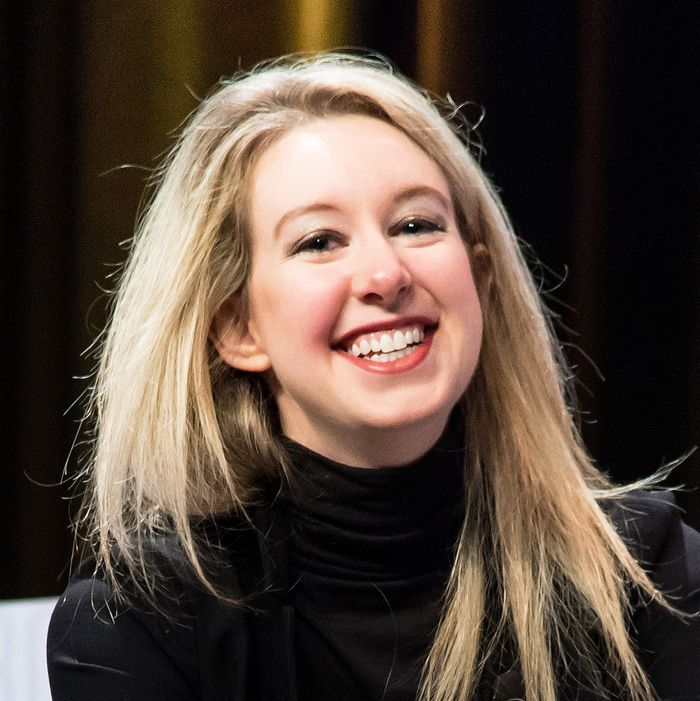

In [ ]:
print("Picture of smiling woman")
Image("holmes.jpg")

In [ ]:
raw_predict("holmes.jpg")

Could not find the HAAR face detector location
Loading the model
Reading the landmark detector/tracker from: ./OpenFace/build/bin/model/main_ceclm_general.txt
Reading the landmark detector module from: ./OpenFace/build/bin/model/cen_general.txt
Reading the PDM module from: ./OpenFace/build/bin/model/pdms/In-the-wild_aligned_PDM_68.txt....Done
Reading the Triangulations module from: ./OpenFace/build/bin/model/tris_68.txt....Done
Reading the intensity CEN patch experts from: ./OpenFace/build/bin/model/patch_experts/cen_patches_0.25_of.dat....Done
Reading the intensity CEN patch experts from: ./OpenFace/build/bin/model/patch_experts/cen_patches_0.35_of.dat....Done
Reading the intensity CEN patch experts from: ./OpenFace/build/bin/model/patch_experts/cen_patches_0.50_of.dat....Done
Reading the intensity CEN patch experts from: ./OpenFace/build/bin/model/patch_experts/cen_patches_1.00_of.dat....Done
Reading part based module....left_eye_28
Reading the landmark detector/tracker from: ./OpenF

A picture of smiling woman is predicted as more than average happy by Random Forest model. 

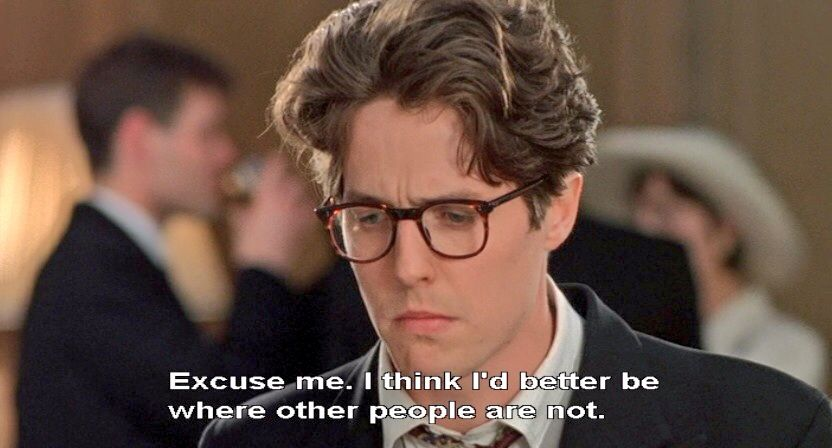

In [ ]:
print("Picture of man looking down")
Image("sadman2.jpg")

In [ ]:
raw_predict("sadman2.jpg")

Could not find the HAAR face detector location
Loading the model
Reading the landmark detector/tracker from: ./OpenFace/build/bin/model/main_ceclm_general.txt
Reading the landmark detector module from: ./OpenFace/build/bin/model/cen_general.txt
Reading the PDM module from: ./OpenFace/build/bin/model/pdms/In-the-wild_aligned_PDM_68.txt....Done
Reading the Triangulations module from: ./OpenFace/build/bin/model/tris_68.txt....Done
Reading the intensity CEN patch experts from: ./OpenFace/build/bin/model/patch_experts/cen_patches_0.25_of.dat....Done
Reading the intensity CEN patch experts from: ./OpenFace/build/bin/model/patch_experts/cen_patches_0.35_of.dat....Done
Reading the intensity CEN patch experts from: ./OpenFace/build/bin/model/patch_experts/cen_patches_0.50_of.dat....Done
Reading the intensity CEN patch experts from: ./OpenFace/build/bin/model/patch_experts/cen_patches_1.00_of.dat....Done
Reading part based module....left_eye_28
Reading the landmark detector/tracker from: ./OpenF

A picture of man looking down is predicted as somewhat happy by the Random Forest model. This is inaccurate, because he is clearly not happy at all. Random Forest is not very good with non-happy images because not many training set images contain non-happy people. The person is looking down, and many images in the training set has people looking down on the cake and being happy, so this is another possible reason of why the Random Forest misclassifies. 

Picture of man smiling slightly


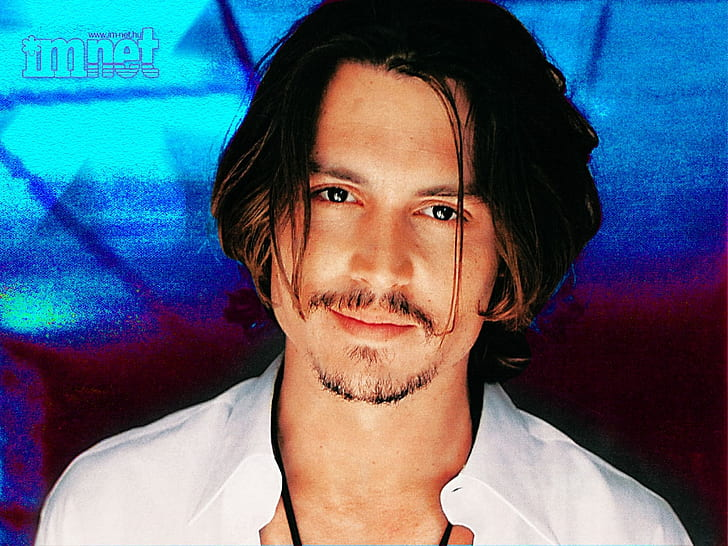

In [ ]:
print("Picture of man smiling slightly")
Image("smile_john.jpg")

In [ ]:
raw_predict("smile_john.jpg")

Could not find the HAAR face detector location
Loading the model
Reading the landmark detector/tracker from: ./OpenFace/build/bin/model/main_ceclm_general.txt
Reading the landmark detector module from: ./OpenFace/build/bin/model/cen_general.txt
Reading the PDM module from: ./OpenFace/build/bin/model/pdms/In-the-wild_aligned_PDM_68.txt....Done
Reading the Triangulations module from: ./OpenFace/build/bin/model/tris_68.txt....Done
Reading the intensity CEN patch experts from: ./OpenFace/build/bin/model/patch_experts/cen_patches_0.25_of.dat....Done
Reading the intensity CEN patch experts from: ./OpenFace/build/bin/model/patch_experts/cen_patches_0.35_of.dat....Done
Reading the intensity CEN patch experts from: ./OpenFace/build/bin/model/patch_experts/cen_patches_0.50_of.dat....Done
Reading the intensity CEN patch experts from: ./OpenFace/build/bin/model/patch_experts/cen_patches_1.00_of.dat....Done
Reading part based module....left_eye_28
Reading the landmark detector/tracker from: ./OpenF

A picture of smiling man is predicted as more than average happy by Random Forest model. 

A woman staring


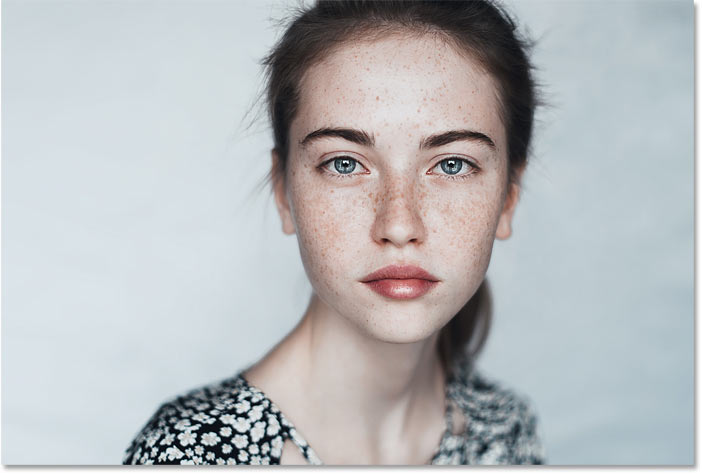

In [ ]:
print("A woman staring")
Image("stare.jpg")

In [ ]:
raw_predict("stare.jpg")

Could not find the HAAR face detector location
Loading the model
Reading the landmark detector/tracker from: ./OpenFace/build/bin/model/main_ceclm_general.txt
Reading the landmark detector module from: ./OpenFace/build/bin/model/cen_general.txt
Reading the PDM module from: ./OpenFace/build/bin/model/pdms/In-the-wild_aligned_PDM_68.txt....Done
Reading the Triangulations module from: ./OpenFace/build/bin/model/tris_68.txt....Done
Reading the intensity CEN patch experts from: ./OpenFace/build/bin/model/patch_experts/cen_patches_0.25_of.dat....Done
Reading the intensity CEN patch experts from: ./OpenFace/build/bin/model/patch_experts/cen_patches_0.35_of.dat....Done
Reading the intensity CEN patch experts from: ./OpenFace/build/bin/model/patch_experts/cen_patches_0.50_of.dat....Done
Reading the intensity CEN patch experts from: ./OpenFace/build/bin/model/patch_experts/cen_patches_1.00_of.dat....Done
Reading part based module....left_eye_28
Reading the landmark detector/tracker from: ./OpenF

A picture of staring woman is predicted as a little happy by Random Forest model. When the training dataset is being made, we classified neutral people with cake as a little happy because a person rarely have absolutely no emotion at a moment, and the woman in the picture acted neutral in the photo, so it makes sense for the model to classify her as being a little happy. 

## Conclusion from testing the model with real data

Our Random Forest model is more accurate at predicting intensity of people's happiness than identifying happy people, and this is likely due to our dataset consisting mostly of pictures of happy people.




## Future Improvement

Future research can improve our models by feeding them with more broad datasets. That is, dataset with pictures of many non-happy people.